Ticker: SH
Optional MAperiod: 27
Most recent BUY signal: 2020-02-25
*** BUY SCREENER SIGNAL


<IPython.core.display.Javascript object>


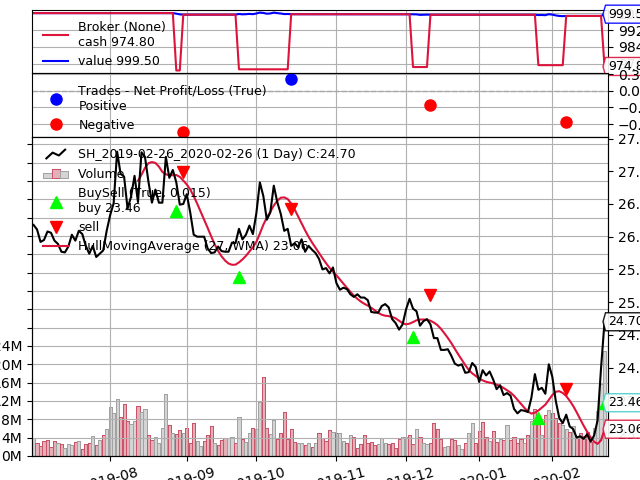

In [41]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
from datetime import date, datetime, timedelta

# Import the backtrader platform
import backtrader as bt

period = 365
strategyResults = {}
lastBuy = None
optimization = True
ETFs =['SPY', 'SH', 'VXX', 'EEM', 'QQQ', 'PSQ', 'XLF', 'GDX', 'HYG', 'EFA', 'IAU', 'XOP', 'IWM', 'FXI', 'SLV', 'USO', 'XLE', 'IEMG', 'AMLP', 'EWZ', 'XLK', 'XLI', 'VWO', 'GLD', 'XLP', 'JNK', 'EWJ', 'XLU', 'VEA', 'IEFA', 'XLV', 'PFF', 'VIXY', 'TLT', 'GDXJ', 'LQD', 'XLB', 'BKLN', 'XLY', 'SMH', 'OIH', 'ASHR', 'RSX', 'MCHI', 'VTI', 'EWH', 'SPLV', 'KRE', 'IVV', 'DIA', 'IEF', 'EZU', 'EWT', 'SPDW', 'VOO', 'SCHF', 'EWY', 'MYY', 'DOG', 'EUM']

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 20),
    )

    def log(self, txt, optimization=False, dt=None):
        if optimization:
            return
        
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.hma = bt.indicators.HullMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        global lastBuy
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                lastBuy = self.datas[0].datetime.date(0)
                self.log(
                    'BUY EXECUTED, Price: $%.2f, Cost: $%.2f ($Comm %.2f)' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm), optimization=optimization)

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: $%.2f, Cost: $%.2f (Comm $%.2f)' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm), optimization=optimization)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected', optimization=optimization)

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION GROSS $%.2f, NET $%.2f, PROFIT %.2f%%' %
                 (trade.pnl, trade.pnlcomm, trade.pnlcomm/trade.price*100), optimization=optimization)
        

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            # check for HMA trend reversal
            if self.hma[-2] >= self.hma[-1] and \
               self.hma[-1] < self.hma[0]:

                self.log('BUY CREATE, $%.2f' % self.dataclose[0], optimization=optimization)

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:
            # check for HMA trend reversal
            if self.hma[-2] <= self.hma[-1] and \
               self.hma[-1] > self.hma[0]:

                self.log('SELL CREATE, $%.2f' % self.dataclose[0], optimization=optimization)

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.maperiod, self.broker.getvalue()), optimization=optimization)
        
        # keep track of results for each period backtest
        strategyResults[self.params.maperiod] = self.broker.getvalue()



if __name__ == '__main__':

    if True:
        ticker = 'SH'
#    for ticker in ETFs:
        print('Ticker: %s' % ticker)
        # Create a cerebro entity
        cerebro = bt.Cerebro()

        strats = cerebro.optstrategy(
            TestStrategy,
            maperiod=range(15, 30))

        endDate = datetime.today().strftime('%Y-%m-%d')
        fromDate = (datetime.today() - timedelta(days=period))
        startDate = fromDate.strftime('%Y-%m-%d')
        filename = '%s_%s_%s.txt' % (ticker,startDate, endDate)
        modpath = os.path.dirname(os.path.abspath('./Quant'))
        datapath = os.path.join(modpath, filename)

        if not os.path.isfile(filename):
            print('file: %s not found' % filename)
            sys.exit()

        # Section (1)
        # Find the optimal MA period for this equity in this data set
        
        # Create a Data Feed
        data = bt.feeds.YahooFinanceCSVData(
            dataname=datapath,
            # Do not pass values before this date
            fromdate=datetime(fromDate.year, fromDate.month, fromDate.day),
            # Do not pass values before this date
            todate=datetime(datetime.today().year, datetime.today().month, datetime.today().day),
            # Do not pass values after this date
            reverse=False)

        # Add the Data Feed to Cerebro
        cerebro.adddata(data)
        # Set our desired cash start
        cerebro.broker.setcash(1000.0)
        # Add a FixedSize sizer according to the stake
        cerebro.addsizer(bt.sizers.FixedSize, stake=1)
        # Set the commission
        cerebro.broker.setcommission(commission=0.0)

        optimization = True
        # Run over everything
        cerebro.run(maxcpus=1)

        # find the optimal period for this indicator and this data
        inverse = [(value, key) for key, value in strategyResults.items()]
        bestPeriod = max(inverse)[1]
        print('Optional MAperiod: %s' % str(bestPeriod))

        # Section (2)
        # Use the optimal MA period to backtest over the past 4 months to find most recent signal
        
        fromDate = (datetime.today() - timedelta(days=240))
        # Recreate a cerebro entity
        cerebro = bt.Cerebro()
        # Create a Data Feed
        data = bt.feeds.YahooFinanceCSVData(
            dataname=datapath,
            # Do not pass values before this date
            fromdate=datetime(fromDate.year, fromDate.month, fromDate.day),
            # Do not pass values before this date
            todate=datetime(datetime.today().year, datetime.today().month, datetime.today().day),
            # Do not pass values after this date
            reverse=False)
        # Add the Data Feed to Cerebro
        cerebro.adddata(data)
        # Set our desired cash start
        cerebro.broker.setcash(1000.0)
        # Add a FixedSize sizer according to the stake
        cerebro.addsizer(bt.sizers.FixedSize, stake=1)
        # Set the commission
        cerebro.broker.setcommission(commission=0.0)

        # Print out the starting conditions
        if not optimization:
            print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

        #optimization = False
        # Add a strategy
        cerebro.addstrategy(TestStrategy, maperiod = bestPeriod)
        # Run over everything
        cerebro.run()

        # Print out the final result
        if not optimization:
            print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

        print ('Most recent BUY signal: %s' % lastBuy)
        if (datetime.today().date() - lastBuy).days < 2:
            print ('*** BUY SCREENER SIGNAL')
            # Plot the result
            cerebro.plot(numfigs=1)